# Scraping the Courts and Tribunals Judiciary Website to collect Prevent Future Death (PFD) reports 

In [1]:
from requests import get
from requests import ConnectionError
from bs4 import BeautifulSoup
import re
from time import sleep
from time import time
import csv
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from tqdm.contrib import tzip

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import concurrent

from time import sleep, time


from datetime import date

def get_url(url):
    return BeautifulSoup(get(url, verify = False).content, "html.parser")

def retries(record_url, tries=3):
    for i in range(tries):
        try:
            soup = get_url(record_url)
            return soup
        except (ConnectionError, SSLError):
            sleep(2)
            continue
    raise ConnectionError(f"Exceeded {tries} tries")

# Scraper starts here - last run on Monday, 06 Sept 2021, 9.06 am.

Here we find the number of pages containing PFD reports.

In [2]:
prefix = "https://www.judiciary.uk/subject/prevention-of-future-deaths/"
number_of_pages = int(get_url(prefix) \
                    .find("div", "pagination") \
                    .find_all("li")[-1] \
                    .find("a")["href"] \
                    .split("/")[-2])

In [3]:
def fetch_urls(page):
    soup = retries(prefix+"/page/{}".format(str(page+1)))
    h5s = soup.find_all('h5', {'class': 'entry-title'})
    return [h5.a.get('href') for h5 in h5s]

In [4]:
record_urls = []
with tqdm(total = number_of_pages) as pbar:
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        record_urls = [executor.submit(fetch_urls, i)
                       for i in range(number_of_pages)]
        for future in concurrent.futures.as_completed(record_urls):
            pbar.update(1)
record_urls = [link for links in # flatten the list
                   [urls.result() for urls in record_urls]
                   for link in links]

  0%|          | 0/371 [00:00<?, ?it/s]

Some technical remarks: we make all our web requests here to avoid repeatedly making requests to the judiciary’s website. Since `concurrent` must pickle the object we can’t nicely handle exceptions so just have to check the output of `download_html` later for strings beginning `Error: ` (on the assumption that most pages won’t start `Error: `.)

Only the download part is parallelised, on the assumption that downloads are slow but relatively simple to parallelise, and all other operations are finicky but are fast even on a single thread.

It is envisaged that there should be no need to refresh these cells so as to save time.

In [5]:
def download_html(url, tries=5):
    try:
        for i in range(tries):
            try:
                return get(url)
            except (ConnectionError, SSLError):
                sleep(2)
                continue
    except Exception as e:
        if isinstance(e, ConnectionError):
            return "Error: Connection error"
        else:
            return f"Error: {str(e)}"

In [6]:
with tqdm(total = len(record_urls)) as pbar:
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        raw = [executor.submit(download_html, url) for url in record_urls]
        for future in concurrent.futures.as_completed(raw):
            pbar.update(1)

  0%|          | 0/3708 [00:00<?, ?it/s]

In [7]:
class MissingRecordsError(Exception): pass
class MissingFieldError(Exception): pass
class UnreadableFieldError(Exception): pass
class FieldError(Exception): pass
class SpecialCaseUnaccountedForError(Exception): pass
class TooManyTriesError(Exception): pass
class MissingDownloadBoxError(Exception): pass

special_cases = [
    "https://www.judiciary.uk/publications/roadsafety/",
    "https://www.judiciary.uk/publications/helen-sheath/",
    "https://www.judiciary.uk/publications/rebecca-evans/"
]

columns = list(map(lambda x: x.lower(), [
    'Date of report',
    'Ref',
    'Deceased name',
    'Coroner name',
    'Coroner Area',
    'Coroners Area', #NB to be merged later; if both come up there'll be trouble
    'Category',
    "This report is being sent to"
]))

records, refs, pdflinks = [], [], []

plurals_possessives = re.compile(r"’s\s|s\s|'s\s")

In [8]:
class Extractor(object):
    def __init__(self, raw_with_url):
        try:
            self.url = raw_with_url[0]
            self.extracted = {"url": self.url, "errors": []}

            self.result = raw_with_url[1].result()
            
            if isinstance(self.result, str):
                if self.result.startswith("Error:"):
                    raise ConnectionError
            
            self.read_fields()
            self.count_files()
        except Exception as e:
            self.handle_exception(e)
            
    def read_fields(self):
        self.soup = BeautifulSoup(self.result.content)
        self.information_area = self.soup.find("div", {"class": "entry-content"})

        if not self.information_area:
            raise MissingRecordsError         

        self.information = self.information_area.find_all("p")

        # nothing between <p> to process
        if not self.information:
            raise MissingRecordsError         
        
        if self.url in special_cases:
            self._process_special_case(self.url)
        else:
             for field in self.information:
                self.strip_field(field)

    def count_files(self):
        download_box = self.soup.find("div", "download-box")

        if download_box:
            links = download_box.find_all('a', href=True)
            responses = len([s for s in links if "response" in s.text.lower()])
        else:
            raise MissingDownloadBoxError

        pdflinks.append([link.href for link in links])

        self.extracted["number of links"] = len(links)
        self.extracted["number of responses"] = responses

        try:
            self.extracted["number of recipients"] = self.extracted["this report is being sent to"].count(";") + 1
        except:
            pass

        try:
            if self.extracted["ref"] in refs: # deduplication of references
                self.extracted["ref"] += "-bis"
            refs.append(self.extracted["ref"])
        except KeyError:
            self.extracted["ref"] = "autogenerated-ref" # no reference found
    
    def handle_exception(self, e):
        details = str(e)
        if isinstance(e, ConnectionError):
            details = "Could not connect"
        if isinstance(e, MissingRecordsError):
            details = "No records found"
        if isinstance(e, SpecialCaseUnaccountedForError):
            details = "Special case unaccounted for"
        if isinstance(e, MissingFieldError):
            details = f"Missing header: {e}"
        if isinstance(e, AttributeError):
            details = f"Attribute error: {e}"
        if isinstance(e, MissingDownloadBoxError):
            details = f"Missing download box."
        print(f"At {self.url}, {details}")
        self.extracted["errors"].append({"url": self.url, "reason": details})

    def strip_field(self, field):
        try:
            extraction = self.FieldStripper(field, self.url)
            self.extracted[extraction.header] = extraction.text
            if extraction.error is not None:
                self.extracted["errors"].append(extraction.error)
        except FieldError:
            self.extracted["errors"].append({"url": self.url, "reason": f"Field error: {field}"})
            
    def _process_special_case(self,url):
        if self.url == 'https://www.judiciary.uk/publications/roadsafety/':
            fields = self.information[0].find_all('strong')
            heads = ['date of report',
                     'ref',
                     'deceased name',
                     'coroner name',
                     'coroner area',
                     'category']
            for field, h in zip(fields,heads):
                self.extracted[h] = field.next_sibling.replace(':','').replace('Ref','').strip()
        elif url == 'https://www.judiciary.uk/publications/helen-sheath/':
            fields = self.information[0].text.split('\n')
            vals = [field.split(":") for field in fields]
            for v in vals:
                if v[0] == "Coroners name":
                    alt = "coroner_name"
                elif v[0] == "Coroners Area":
                    alt = "coroner_area"
                else:
                    alt = v[0].strip().lower()
                self.extracted[alt] = v[1].strip().replace('\n','')
        elif url == "https://www.judiciary.uk/publications/rebecca-evans/":
            for field in self.information:
                if "Rebecca-EvansR" in field.text:
                    self.extracted["category"] = field.text.split(':')[1].strip().replace('\n','')
                else:
                    self.strip_field(field)

        else:
            raise SpecialCaseUnaccountedForError

            
            
    class FieldStripper(object):
        def __init__(self, field, url):
            try:
                self.error = None
                self.url = url
                self.field_text = field.text.strip()
                self.text = ""

                if self.field_text.replace('\xa0','').strip() == "": raise MissingFieldError

                    
                if ":" in self.field_text:
                    self.pre_colon, self.post_colon = self.field_text.split(":", 1) # split by first colon
                else:
                    self.pre_colon = self.field_text
                    self.post_colon = ""
                
                
                self.header = self.pre_colon.lower()
                
                if self.header in columns: # Normal case: colon separates text
                    self.text = self.post_colon.strip().replace('\n','').replace('\xa0','')
                elif self.post_colon.strip() == "": # no colon separator
                    self.header, self.text = self._no_colon_separator()          
                elif self.field_text.count(":") == 2: # two colons
                    self.header, self.text = self._two_colons()
                elif ':' in self.field_text and self.header not in columns: # plurals and possessives
                    self.header, self.text = self._plurals_and_possessives()
                else:
                    print(self.field_text)
                
            except Exception as e:
                details = str(e)
                if isinstance(e, UnreadableFieldError):
                    details = f"Unreadable field; text read: {field.text}"              
                if isinstance(e, MissingFieldError):
                    details = f"Unreadable field; text read: {field.text}"              
                self.error = {"url": self.url, "reason": details}
                raise FieldError

        def _no_colon_separator(self):
            column_found = False
            for column in columns:
                if self.pre_colon.startswith(column):
                    header = column
                    text = pre_colon[len(column)+1] \
                            .replace('\n','') \
                            .replace('\xa0','')
                    column_found = True
                    break
            if not column_found:
                raise UnreadableFieldError
            return (header, text)

        def _two_colons(self):
            split_by_colon = self.field_text.split(':')
            header = re.sub(plurals_possessives,
                             ' ',
                             split_by_colon[0]+split_by_colon[1]
                            ) \
                            .strip() \
                            .lower()
            text = split_by_colon[2] \
                        .strip() \
                        .replace('\n','') \
                        .replace('\xa0','')
            return (header, text)

        def _plurals_and_possessives(self):
            if 'Name of' in self.field_text:
                header = self.pre_colon.split(' ')[2] + " name"
                text = self.field_text[-1].strip().replace('\n','').replace('\xa0','')
            else:     
                header = re.sub(plurals_possessives, ' ', self.pre_colon).strip().lower()
                text = self.post_colon.strip().replace('\n','').replace('\xa0','')
            return (header, text)

def page_scrape(raw_with_url):
    scraper = Extractor(raw_with_url)
    return scraper.extracted

In [9]:
records = [page_scrape(page) for page in tzip(record_urls, raw)]
errors = [record["errors"] for record in records if record["errors"] != []]

  0%|          | 0/3708 [00:00<?, ?it/s]

At https://www.judiciary.uk/publications/john-long/, Missing download box.
At https://www.judiciary.uk/publications/patricia-parker/, Missing download box.
At https://www.judiciary.uk/publications/railwayrelateddeaths/, No records found
At https://www.judiciary.uk/publications/service-personnel-deaths/, No records found
At https://www.judiciary.uk/publications/product/, No records found
At https://www.judiciary.uk/publications/policerelateddeaths/, No records found
At https://www.judiciary.uk/publications/carehomehealth/, No records found
At https://www.judiciary.uk/publications/statecustodydeath/, No records found
At https://www.judiciary.uk/publications/hospitaldeath/, No records found
At https://www.judiciary.uk/publications/drugsalcoholmedication/, No records found
At https://www.judiciary.uk/publications/commhealthcareemergencyservices/, No records found


We place `records` into a data frame and merge different labels for the same field.

In [10]:
df = pd.DataFrame(records)
df["coroner area"] = df["coroner area"].fillna(df["coroners area"])
df["date of report"] = df["date of report"].fillna(df["date of reports"])

Here we plot the number of reports every month.

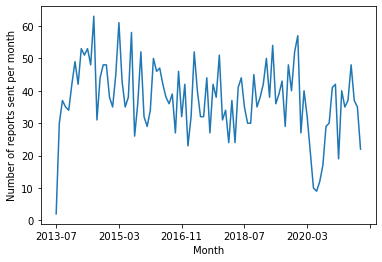

In [11]:
df["date of report"] = pd.to_datetime(df["date of report"], errors = 'coerce')
df["year-month"] = df["date of report"].dropna().apply(lambda dmy: dmy.strftime('%Y-%m'))
date_counts = df["year-month"].dropna().value_counts().sort_index()

date_plot = date_counts.plot

plt.xlabel("Month")
plt.ylabel("Number of reports sent per month")

date_plot.line()

plt.savefig("reports-per-month.svg")

It is slightly more involved to do so, but here we plot the response rate. We categorise the response rate into threee categories—
1. where no response is received,
2. where fewer responses are received than the number of bodies to which the report was sent, and
3. when the number of responses received is equal to or greater than the number of bodies to which the report was sent.

We adopt this rather convoluted scheme because in certain cases multiple responses are received even though the report was only sent to one body (for example, a CCG may respond in addition to someone from a particular hospital).

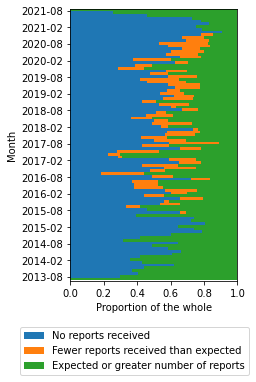

In [12]:
def get_response_rate(row):
    if row["number of responses"] == 0:
        return "no response received"
    elif row["number of responses"] < row["number of recipients"]:
        return "fewer responses than expected received"
    else:
        return "expected or greater number of responses received"

response_rates = df.loc[:,["year-month", "number of responses", "number of recipients"]]
response_rates["response"] = response_rates.apply(get_response_rate, axis=1)
response_rates = response_rates \
        .groupby(["year-month"])["response"] \
        .value_counts() \
        .to_frame() \
        .unstack() \
        .fillna(0)

proportions = response_rates.div(response_rates.sum(axis=1), axis=0)

proportions_plot = proportions.plot(kind="barh",stacked=True, figsize=(3,5))

for container in proportions_plot.containers:
    plt.setp(container, height=1)
    
plt.tick_params(axis='both', which='both')

plt.xlabel("Proportion of the whole")
plt.ylabel("Month")

plt.yticks(plt.yticks()[0][1::6], 
           plt.yticks()[1][1::6])

plt.legend(labels=["No reports received", "Fewer reports received than expected", "Expected or greater number of reports"],bbox_to_anchor=(1.1,-0.15))
plt.margins(0)

plt.savefig("responses-over-time.svg",bbox_inches='tight')

plt.show()

Here we redact the names for public display and then export the CSV file.

In [16]:
%%capture

csv_output = df.loc[:,["date of report", "ref", "deceased name", "deceased names", "coroner name", "coroner area", "category", "this report is being sent to", "url"]]

def process_name(full_name):
    if full_name == "": return ""
    else: return "".join(name[0] for name in full_name.split(" "))

def process_names(names):
    output = []
    and_split = names.split(" and ", 1)
    if len(and_split) > 1: output.append(and_split[1])
    output += and_split[0].split(", ")
    print(output)
    return ", ".join([process_name(name) for name in output])

csv_output["deceased names"] = csv_output["deceased names"].fillna(df["deceased name"])
csv_output["deceased names"].fillna("",inplace=True)
csv_output["deceased names"].apply(process_names)

In [17]:
csv_output[["date of report", "ref", "deceased names", "coroner name", "coroner area", "category", "this report is being sent to", "url"]].to_csv(f"death_info_{str(date.today())}_processed.csv")

csv_output[["date of report", "ref", "deceased names", "coroner name", "coroner area", "category", "this report is being sent to", "url"]].to_csv(f"death_info_latest.csv")

We save the file twice, possibly overwriting `death_info_latest.csv` so that `index.html` can point to the same location and it doesn’t need to be changed.